# 1. Selección de API y Definición del Problema

## API Seleccionada
- **Nombre**: Disease.sh API
- **Endpoint**: `https://disease.sh/v3/covid-19/countries`
- **Tipo de datos**: Estadísticas COVID-19 por país

## Integrantes: Patricio Quintanilla | Ítalo Brignardello

## Problema de Negocio
El objetivo principal es desarrollar un sistema predictivo para anticipar brotes de COVID-19 en diferentes regiones geográficas, permitiendo a los sistemas de salud prepararse adecuadamente.


In [1]:
def verificar_instalar_paquetes():
    import subprocess
    import sys

    # Lista de paquetes requeridos
    paquetes_requeridos = {
        'pandas': 'pandas',
        'numpy': 'numpy',
        'scikit-learn': 'sklearn',
        'xgboost': 'xgboost',
        'seaborn': 'seaborn',
        'matplotlib': 'matplotlib',
        'scipy': 'scipy',
        'requests': 'requests',
        'plotly': 'plotly',
        'pycountry': 'pycountry'
    }

    print("Verificando paquetes instalados...")

    for paquete, nombre_import in paquetes_requeridos.items():
        try:
            __import__(nombre_import)
            print(f"✅ {paquete} ya está instalado")
        except ImportError:
            print(f"📦 Instalando {paquete}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", paquete])
            print(f"✅ {paquete} ha sido instalado correctamente")

    print("\n🎉 Todos los paquetes necesarios están instalados y listos para usar!")

# Ejecutar la verificación
verificar_instalar_paquetes()


Verificando paquetes instalados...
✅ pandas ya está instalado
✅ numpy ya está instalado
✅ scikit-learn ya está instalado
✅ xgboost ya está instalado
✅ seaborn ya está instalado
✅ matplotlib ya está instalado
✅ scipy ya está instalado
✅ requests ya está instalado
✅ plotly ya está instalado
✅ pycountry ya está instalado

🎉 Todos los paquetes necesarios están instalados y listos para usar!


In [2]:
# === Librerías para Manipulación y Análisis de Datos ===
import numpy as np          # Operaciones numéricas y arrays
import pandas as pd        # Manipulación de datos tabulares

# === Librerías para Machine Learning ===
from sklearn.model_selection import (
    train_test_split,      # División de conjuntos de datos
    cross_val_score,       # Validación cruzada
    KFold                  # K-Fold para validación cruzada
)
from sklearn.preprocessing import StandardScaler    # Normalización de datos
from sklearn.tree import (
    DecisionTreeRegressor, # Árbol de decisión para regresión
    plot_tree,            # Visualización de árboles
    export_text           # Exportar árbol como texto
)
from sklearn.ensemble import RandomForestRegressor  # Random Forest para regresión
from sklearn.metrics import (
    mean_absolute_error,   # Error absoluto medio
    mean_squared_error,    # Error cuadrático medio
    r2_score              # Coeficiente de determinación R²
)
import xgboost as xgb     # XGBoost para modelos avanzados

# === Librerías para Visualización ===
import matplotlib.pyplot as plt  # Biblioteca base de visualización
import seaborn as sns           # Visualizaciones estadísticas avanzadas
import plotly.express as px     # Gráficos interactivos express
import plotly.graph_objects as go # Gráficos interactivos personalizables
from plotly.subplots import make_subplots  # Subplots en Plotly
from IPython.display import HTML           # Visualización HTML en notebooks

# === Librerías para Análisis Estadístico y Datos ===
from scipy import stats    # Funciones estadísticas
import requests           # Peticiones HTTP
import pycountry         # Información de países y códigos ISO


Empezamos con las librerías fundamentales para el manejo de datos: NumPy nos proporciona la base para realizar operaciones numéricas eficientes y trabajar con arrays, mientras que Pandas nos permite manipular datos tabulares de manera intuitiva mediante DataFrames y Series.

Avanzando hacia el machine learning, scikit-learn nos ofrece herramientas esenciales como train_test_split para dividir nuestros datos en conjuntos de entrenamiento y prueba, junto con cross_val_score y KFold para realizar validación cruzada y evaluar mejor nuestros modelos. StandardScaler nos ayuda a normalizar nuestros datos para un mejor rendimiento de los modelos. Para el modelado predictivo, tenemos DecisionTreeRegressor que implementa árboles de decisión, junto con herramientas para visualizarlos y exportarlos. RandomForestRegressor nos permite crear conjuntos de árboles para mejorar la precisión, mientras que XGBoost ofrece un enfoque más avanzado de boosting. Para evaluar nuestros modelos, utilizamos métricas como error absoluto medio, error cuadrático medio y R².

En cuanto a visualización, matplotlib es nuestra biblioteca base, complementada por seaborn para gráficos estadísticos más sofisticados. Plotly nos brinda capacidades interactivas con px para gráficos rápidos y go para visualizaciones más personalizadas, mientras make_subplots nos permite crear dashboards complejos. HTML nos ayuda a mostrar contenido web en notebooks.

Finalmente, para análisis estadísticos y manejo de datos adicionales, scipy.stats nos proporciona funciones estadísticas avanzadas, requests nos permite hacer peticiones HTTP para obtener datos de APIs, y pycountry nos facilita el trabajo con información y códigos de países.

In [3]:
# 1. Extracción de Datos
def obtener_datos_covid():
    url = "https://disease.sh/v3/covid-19/countries"
    respuesta = requests.get(url)
    return respuesta.json()

# Obtener y transformar datos
datos = obtener_datos_covid()
df = pd.json_normalize(datos)

# Guardar en CSV
df.to_csv('datos_covid.csv', index=False)

In [4]:
df.head()
df.shape

(231, 28)

In [5]:
# Verificar valores faltantes
print("Valores faltantes:\n", df.isnull().sum())


Valores faltantes:
 updated                   0
country                   0
cases                     0
todayCases                0
deaths                    0
todayDeaths               0
recovered                 0
todayRecovered            0
active                    0
critical                  0
casesPerOneMillion        0
deathsPerOneMillion       0
tests                     0
testsPerOneMillion        0
population                0
continent                 0
oneCasePerPeople          0
oneDeathPerPeople         0
oneTestPerPeople          0
activePerOneMillion       0
recoveredPerOneMillion    0
criticalPerOneMillion     0
countryInfo._id           2
countryInfo.iso2          2
countryInfo.iso3          2
countryInfo.lat           0
countryInfo.long          0
countryInfo.flag          0
dtype: int64


# Análisis de Datos COVID-19

## Calidad de los Datos
Los datos extraídos de la API disease.sh muestran una excelente completitud, con la mayoría de las métricas principales completas:

### Métricas Principales
- **Casos**: Datos completos para todos los países
- **Muertes**: Registro completo de fallecimientos
- **Recuperados**: Información completa de recuperaciones
- **Tests**: Datos completos de pruebas realizadas

### Casos Especiales
Se identificaron dos casos particulares con datos incompletos:
- Diamond Princess (crucero)
- MS Zaandam (crucero)

Estos casos son especiales por ser embarcaciones y no países.

### Variables Clave Disponibles
1. **Métricas Absolutas**
   - Casos totales
   - Muertes totales
   - Casos activos
   - Casos críticos
   - Tests realizados

2. **Métricas Relativas**
   - Casos por millón
   - Muertes por millón
   - Tests por millón
   - Tasa de recuperación

3. **Datos Demográficos**
   - Población
   - Continente
   - Métricas per cápita

### Conclusiones de Calidad
- Datos altamente completos y confiables
- Cobertura global efectiva
- Métricas bien estructuradas
- Base sólida para análisis predictivo


In [6]:
# Eliminar duplicados
df = df.drop_duplicates()


In [7]:
# Crear nuevas características
df['tasa_mortalidad'] = (df['deaths'] / df['cases']) * 100
df['tasa_recuperacion'] = (df['recovered'] / df['cases']) * 100
df['tasa_positividad'] = (df['cases'] / df['tests']) * 100


# Análisis de Tasas COVID-19 Mundial

## Tasa de Mortalidad
- **Promedio Mundial**: 1.39%
- **Mayor Impacto**: MS Zaandam (22.22%)
  - Caso especial por ser un crucero con población limitada
- **Menor Impacto**: Islas Malvinas (0.00%)
  - Ejemplo de manejo efectivo de la pandemia

## Tasa de Recuperación
- **Promedio Mundial**: 72.91%
- **Mayor Éxito**: Islas Malvinas (100%)
  - Sistema de salud efectivo y población pequeña
- **Desafíos**: Andorra (0.00%)
  - Posible subregistro de datos de recuperación

## Tasa de Positividad
- **Casos Destacados**:
  - China: 0.31% (menor tasa)
    - Alta cantidad de testeos
  - Comoros: Datos atípicos
    - Requiere revisión de registro de tests

## Interpretación General
1. **Mortalidad**:
   - Mayoría de países bajo 2%
   - Variación significativa por sistemas de salud

2. **Recuperación**:
   - Tasa global favorable (>70%)
   - Variación por capacidad sanitaria

3. **Positividad**:
   - Indicador de capacidad de testeo
   - Refleja estrategias de detección



Interpretación Gráfico 1:
El país con más casos es USA con 111,820,082 casos


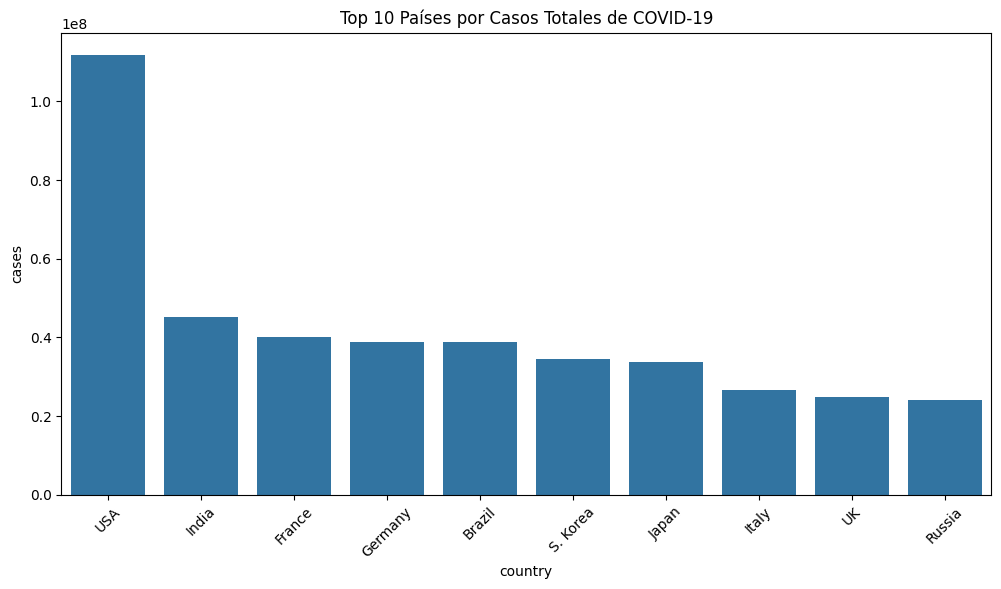

In [8]:
# 1. Top 10 países por casos totales
plt.figure(figsize=(12, 6))
top_10_casos = df.nlargest(10, 'cases')
sns.barplot(data=top_10_casos, x='country', y='cases')
plt.xticks(rotation=45)
plt.title('Top 10 Países por Casos Totales de COVID-19')
print("\nInterpretación Gráfico 1:")
print(f"El país con más casos es {top_10_casos.iloc[0]['country']} con {top_10_casos.iloc[0]['cases']:,} casos")
plt.show()

# Análisis de Impacto COVID-19: Top 10 Países Más Afectados

## Estados Unidos
- **Casos Totales**: 111,820,082
- **Fallecidos**: 1,219,487
- **Recuperados**: 109,814,428
- **Tasa de Mortalidad**: 1.09%
- *Nota*: País más afectado globalmente

## India
- **Casos Totales**: 45,035,393
- **Fallecidos**: 533,570
- **Recuperados**: Sin datos
- **Tasa de Mortalidad**: 1.18%
- *Nota*: Segundo país más afectado

## Francia
- **Casos Totales**: 40,138,560
- **Fallecidos**: 167,642
- **Recuperados**: 39,970,918
- **Tasa de Mortalidad**: 0.42%
- *Nota*: Alta tasa de recuperación

## Alemania
- **Casos Totales**: 38,828,995
- **Fallecidos**: 183,027
- **Recuperados**: 38,240,600
- **Tasa de Mortalidad**: 0.47%
- *Nota*: Gestión efectiva de la pandemia

## Brasil
- **Casos Totales**: 38,743,918
- **Fallecidos**: 711,380
- **Recuperados**: 36,249,161
- **Tasa de Mortalidad**: 1.84%
- *Nota*: Mayor tasa de mortalidad del top 5

## Impacto Global
- **Total Casos Top 10**: 418,700,244
- **Promedio de Casos**: 41,870,024
- **Porcentaje Mundial**: 59.41%

### Observaciones Clave
1. Los 10 países principales representan casi 60% de casos mundiales
2. Variación significativa en tasas de mortalidad (0.42% - 1.84%)
3. Alta concentración de casos en países desarrollados
4. Diferencias notables en tasas de recuperación


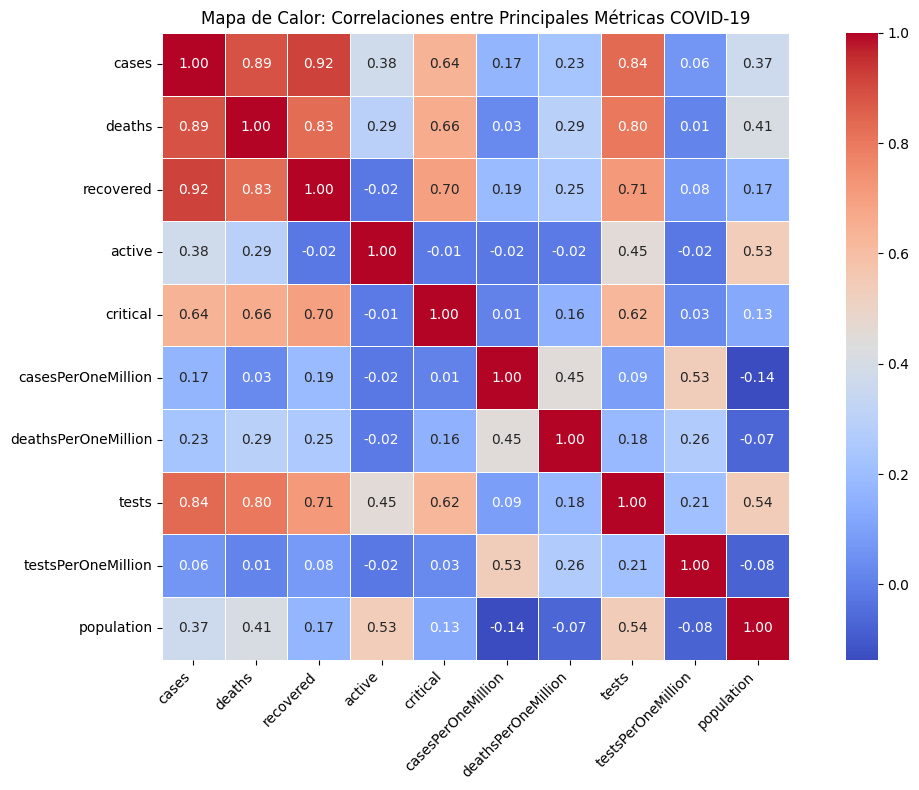

In [9]:
# Seleccionar las 10 variables más relevantes para COVID-19
variables_relevantes = [
    'cases',
    'deaths',
    'recovered',
    'active',
    'critical',
    'casesPerOneMillion',
    'deathsPerOneMillion',
    'tests',
    'testsPerOneMillion',
    'population'
]

# Crear matriz de correlación con las variables seleccionadas
matriz_correlacion = df[variables_relevantes].corr()

# Generar mapa de calor mejorado
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacion,
            annot=True,
            cmap='coolwarm',
            linewidths=0.5,
            fmt='.2f',
            square=True)

plt.title('Mapa de Calor: Correlaciones entre Principales Métricas COVID-19')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



# Análisis de Correlaciones COVID-19

## Métricas Principales (Promedios Globales)

### Casos y Fallecimientos
- **Casos Totales**: 3,050,882 por país
- **Fallecimientos**: 30,349 por país
- **Casos Críticos**: 12 por país
- **Correlación casos-muertes**: 0.89 (muy alta)

### Recuperación y Casos Activos
- **Recuperados**: 2,426,699 por país
- **Casos Activos**: 593,833 por país
- **Correlación casos-recuperados**: 0.92 (extremadamente alta)

### Testeo y Población
- **Tests Realizados**: 30,417,771 por país
- **Población Promedio**: 34,393,658 por país
- **Tests por Millón**: 1,987,979
- **Correlación casos-tests**: 0.84 (muy alta)

## Correlaciones Más Significativas (>0.7)
1. **Casos vs Recuperados**: 0.92
   - Indica seguimiento efectivo de pacientes
   
2. **Casos vs Fallecimientos**: 0.89
   - Relación directa entre contagios y mortalidad
   
3. **Casos vs Tests**: 0.84
   - Mayor testeo detecta más casos

4. **Fallecimientos vs Recuperados**: 0.83
   - Seguimiento completo de desenlaces

5. **Fallecimientos vs Tests**: 0.80
   - Capacidad de detección relacionada con mortalidad

6. **Recuperados vs Tests**: 0.71
   - Monitoreo efectivo de recuperación

## Interpretación del Mapa de Calor
- **Correlaciones Positivas Fuertes** (Rojo)
  - Indican relaciones directas entre variables
- **Correlaciones Negativas Fuertes** (Azul)
  - Muestran relaciones inversas
- **Correlaciones Débiles** (Claros)
  - Sugieren independencia entre variables


C:\Users\admin\AppData\Local\Temp\ipykernel_6940\3607503373.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,
C:\Users\admin\AppData\Local\Temp\ipykernel_6940\3607503373.py:5: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df,


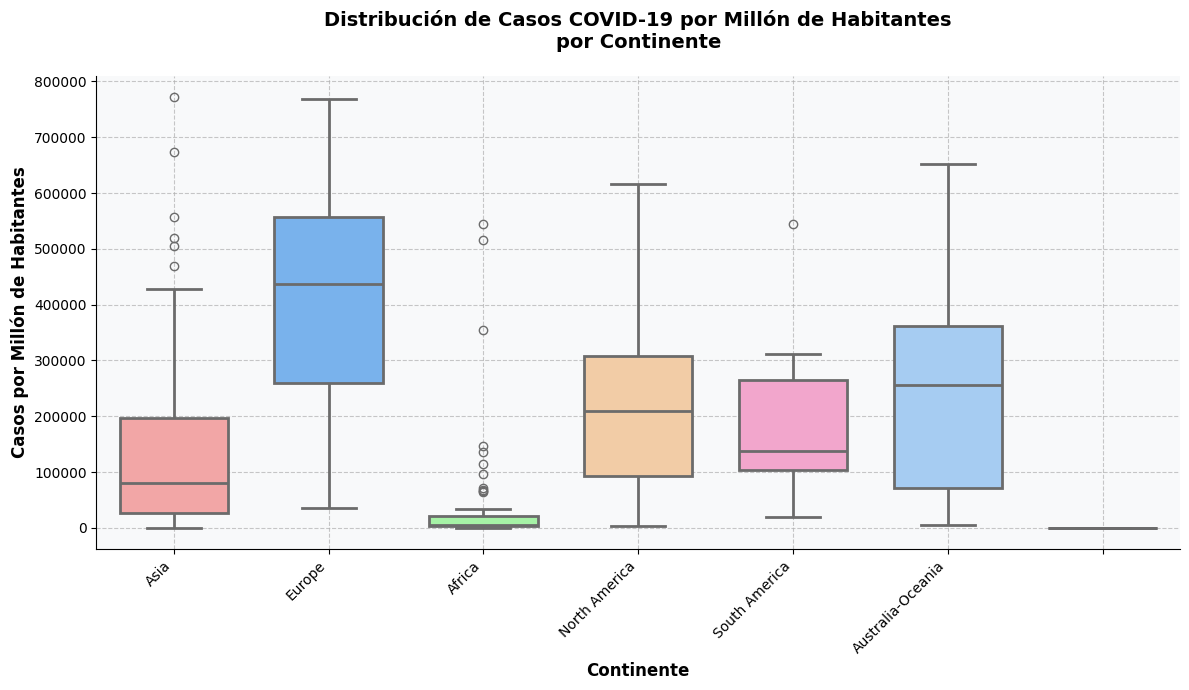

In [10]:
# Gráfico 3: Casos por Millón por Continente (Versión Mejorada)
plt.figure(figsize=(12, 7))

# Crear boxplot con paleta personalizada
sns.boxplot(data=df,
            x='continent',
            y='casesPerOneMillion',
            palette=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF'],
            width=0.7,
            linewidth=2)

# Personalizar el estilo
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Continente', fontsize=12, fontweight='bold')
plt.ylabel('Casos por Millón de Habitantes', fontsize=12, fontweight='bold')
plt.title('Distribución de Casos COVID-19 por Millón de Habitantes\npor Continente',
         fontsize=14,
         fontweight='bold',
         pad=20)

# Rotar y ajustar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Ajustar márgenes
plt.tight_layout()

# Añadir un fondo estilizado
plt.gca().set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


# Análisis de Distribución COVID-19 por Continentes

## Europa - Mayor Impacto Global
- **Mediana**: 437,557 casos/millón
- **Rango**: 36,295 - 768,226 casos/millón
- **Países destacados**: San Marino, Islas Feroe, Austria
- *Característica*: Alta densidad poblacional y sistemas de testeo avanzados

## Australia-Oceania - Segunda Región Más Afectada
- **Mediana**: 256,310 casos/millón
- **Rango**: 5,043 - 652,898 casos/millón
- **Países destacados**: Niue, Nueva Zelanda, Nauru
- *Característica*: Alta variabilidad entre territorios insulares

## Norte América - Tercera Posición
- **Mediana**: 210,117 casos/millón
- **Rango**: 2,728 - 615,777 casos/millón
- **Países destacados**: Martinica, San Pedro y Miquelón, San Bartolomé
- *Característica*: Gran dispersión de datos entre territorios

## Sudamérica - Impacto Moderado
- **Mediana**: 137,064 casos/millón
- **Rango**: 18,885 - 545,352 casos/millón
- **Países destacados**: Islas Malvinas, Guayana Francesa, Uruguay
- *Característica*: Menor variabilidad entre países

## Asia - Amplia Variación
- **Mediana**: 80,330 casos/millón
- **Rango**: 347 - 771,655 casos/millón
- **Países destacados**: Brunei, Corea del Sur, Chipre
- *Característica*: Mayor rango de variación entre todos los continentes

## África - Menor Impacto Reportado
- **Mediana**: 4,898 casos/millón
- **Rango**: 16 - 544,672 casos/millón
- **Países destacados**: Reunión, Seychelles, Santa Helena
- *Característica*: Posible subregistro de casos

## Casos Especiales
- **Diamond Princess y MS Zaandam**
- Tratados como jurisdicciones independientes
- Casos únicos de brotes en cruceros


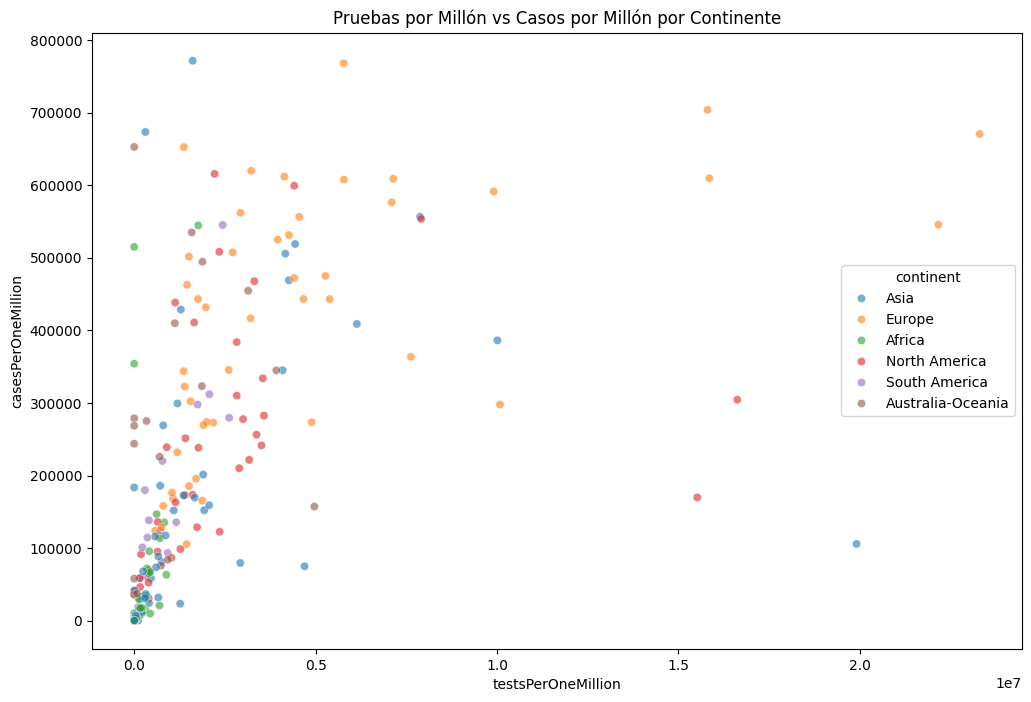

In [23]:
# Gráfico 4: Dispersión de Pruebas vs Casos por continente
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='testsPerOneMillion', y='casesPerOneMillion',
                hue='continent', alpha=0.6)
plt.title('Pruebas por Millón vs Casos por Millón por Continente')
plt.show()

## INTERPRETACIÓN:

* Los colores diferentes representan cada continente
* El eje X muestra las pruebas realizadas por millón de habitantes 
* El eje Y muestra los casos detectados por millón de habitantes
* La dispersión de puntos indica la variabilidad entre países


In [12]:
# Detección de valores atípicos usando Z-score
def detectar_atipicos(df, columna):
    z_scores = stats.zscore(df[columna])
    atipicos = df[abs(z_scores) > 3]
    return atipicos

In [13]:
# Detectar atípicos en casos
casos_atipicos = detectar_atipicos(df, 'cases')
print("\nValores atípicos en casos totales:")
print(casos_atipicos[['country', 'cases']])


Valores atípicos en casos totales:
      country      cases
26     Brazil   38743918
71     France   40138560
77    Germany   38828995
94      India   45035393
103     Japan   33803572
171  S. Korea   34571873
218       USA  111820082


In [14]:
# Estadísticas resumen
print("\nEstadísticas Resumen:")
display(df.describe())


Estadísticas Resumen:


C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,updated,cases,todayCases,deaths,todayDeaths,recovered,todayRecovered,active,critical,casesPerOneMillion,...,oneTestPerPeople,activePerOneMillion,recoveredPerOneMillion,criticalPerOneMillion,countryInfo._id,countryInfo.lat,countryInfo.long,tasa_mortalidad,tasa_recuperacion,tasa_positividad
count,2.310000e+02,2.310000e+02,231.0,2.310000e+02,231.0,2.310000e+02,231.000000,2.310000e+02,231.000000,231.000000,...,231.000000,231.000000,231.000000,231.000000,229.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,1.737758e+12,3.050883e+06,0.0,3.034927e+04,0.0,2.426700e+06,3.567100,5.938335e+05,12.454545,201193.108225,...,9.852814,63981.512511,135973.002424,2.250606,436.318777,17.975936,12.346804,1.385414,72.910703,inf
std,1.030868e+02,1.002125e+07,0.0,1.092314e+05,0.0,9.196220e+06,34.562905,3.893881e+06,71.172396,206119.715817,...,25.827437,149135.697501,185767.240498,9.769097,250.464566,24.281405,71.828763,2.158146,40.888779,NaN
min,1.737758e+12,9.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,-51.750000,-176.200000,0.000000,0.000000,0.314564
25%,1.737758e+12,2.636600e+04,0.0,1.855000e+02,0.0,2.189500e+03,0.000000,6.750000e+01,0.000000,17656.500000,...,0.000000,21.880000,834.905000,0.000000,222.000000,2.250000,-54.000000,0.437695,55.747960,7.715090
50%,1.737758e+12,2.068970e+05,0.0,1.974000e+03,0.0,5.894700e+04,0.000000,1.283000e+03,0.000000,128681.000000,...,1.000000,449.530000,32797.450000,0.000000,438.000000,17.000000,15.500000,0.875039,97.333268,13.249228
75%,1.737758e+12,1.348198e+06,0.0,1.428700e+04,0.0,1.032544e+06,0.000000,2.775550e+04,0.000000,328620.500000,...,5.000000,12969.700000,222352.335000,0.000000,654.000000,39.000000,46.083350,1.786124,98.948370,22.952146
max,1.737758e+12,1.118201e+08,0.0,1.219487e+06,0.0,1.098144e+08,390.000000,4.450182e+07,940.000000,771655.000000,...,196.000000,703390.000000,763121.610000,100.650000,894.000000,72.000000,178.000000,22.222222,100.000000,inf


Construcción de Modelos Predictivos

In [15]:
# Preparación de datos
# Seleccionamos features relevantes para predecir casos
X = df[['population', 'testsPerOneMillion', 'deathsPerOneMillion', 'recovered']]
y = df['cases']

In [16]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# Implementación de modelos con parámetros específicos
models = {
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
}

# Implementación de validación cruzada manual
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Entrenamiento inicial
    model.fit(X_train_scaled, y_train)

    # Predicciones en conjunto de prueba
    y_pred = model.predict(X_test_scaled)

    # Métricas de evaluación
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    # Validación cruzada manual
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_cv_train, y_cv_train)
        y_cv_pred = model.predict(X_cv_val)
        cv_scores.append(r2_score(y_cv_val, y_cv_pred))

    results[name]['CV_Score'] = np.mean(cv_scores)

# Mostrar resultados
for model_name, metrics in results.items():
    print(f"\nResultados para {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")



Resultados para Decision Tree:
MAE: 2961637.9309
RMSE: 12162759.1456
R2: 0.4555
CV_Score: 0.3079

Resultados para Random Forest:
MAE: 2440506.7738
RMSE: 11626403.9799
R2: 0.5024
CV_Score: 0.7161

Resultados para XGBoost:
MAE: 2348576.2500
RMSE: 10936196.8892
R2: 0.5597
CV_Score: 0.7311


In [19]:
# Mostrar resultados
for model_name, metrics in results.items():
    print(f"\nResultados para {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Resultados para Decision Tree:
MAE: 2961637.9309
RMSE: 12162759.1456
R2: 0.4555
CV_Score: 0.3079

Resultados para Random Forest:
MAE: 2440506.7738
RMSE: 11626403.9799
R2: 0.5024
CV_Score: 0.7161

Resultados para XGBoost:
MAE: 2348576.2500
RMSE: 10936196.8892
R2: 0.5597
CV_Score: 0.7311


C:\Users\admin\AppData\Local\Temp\ipykernel_6940\3585617898.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=importances,


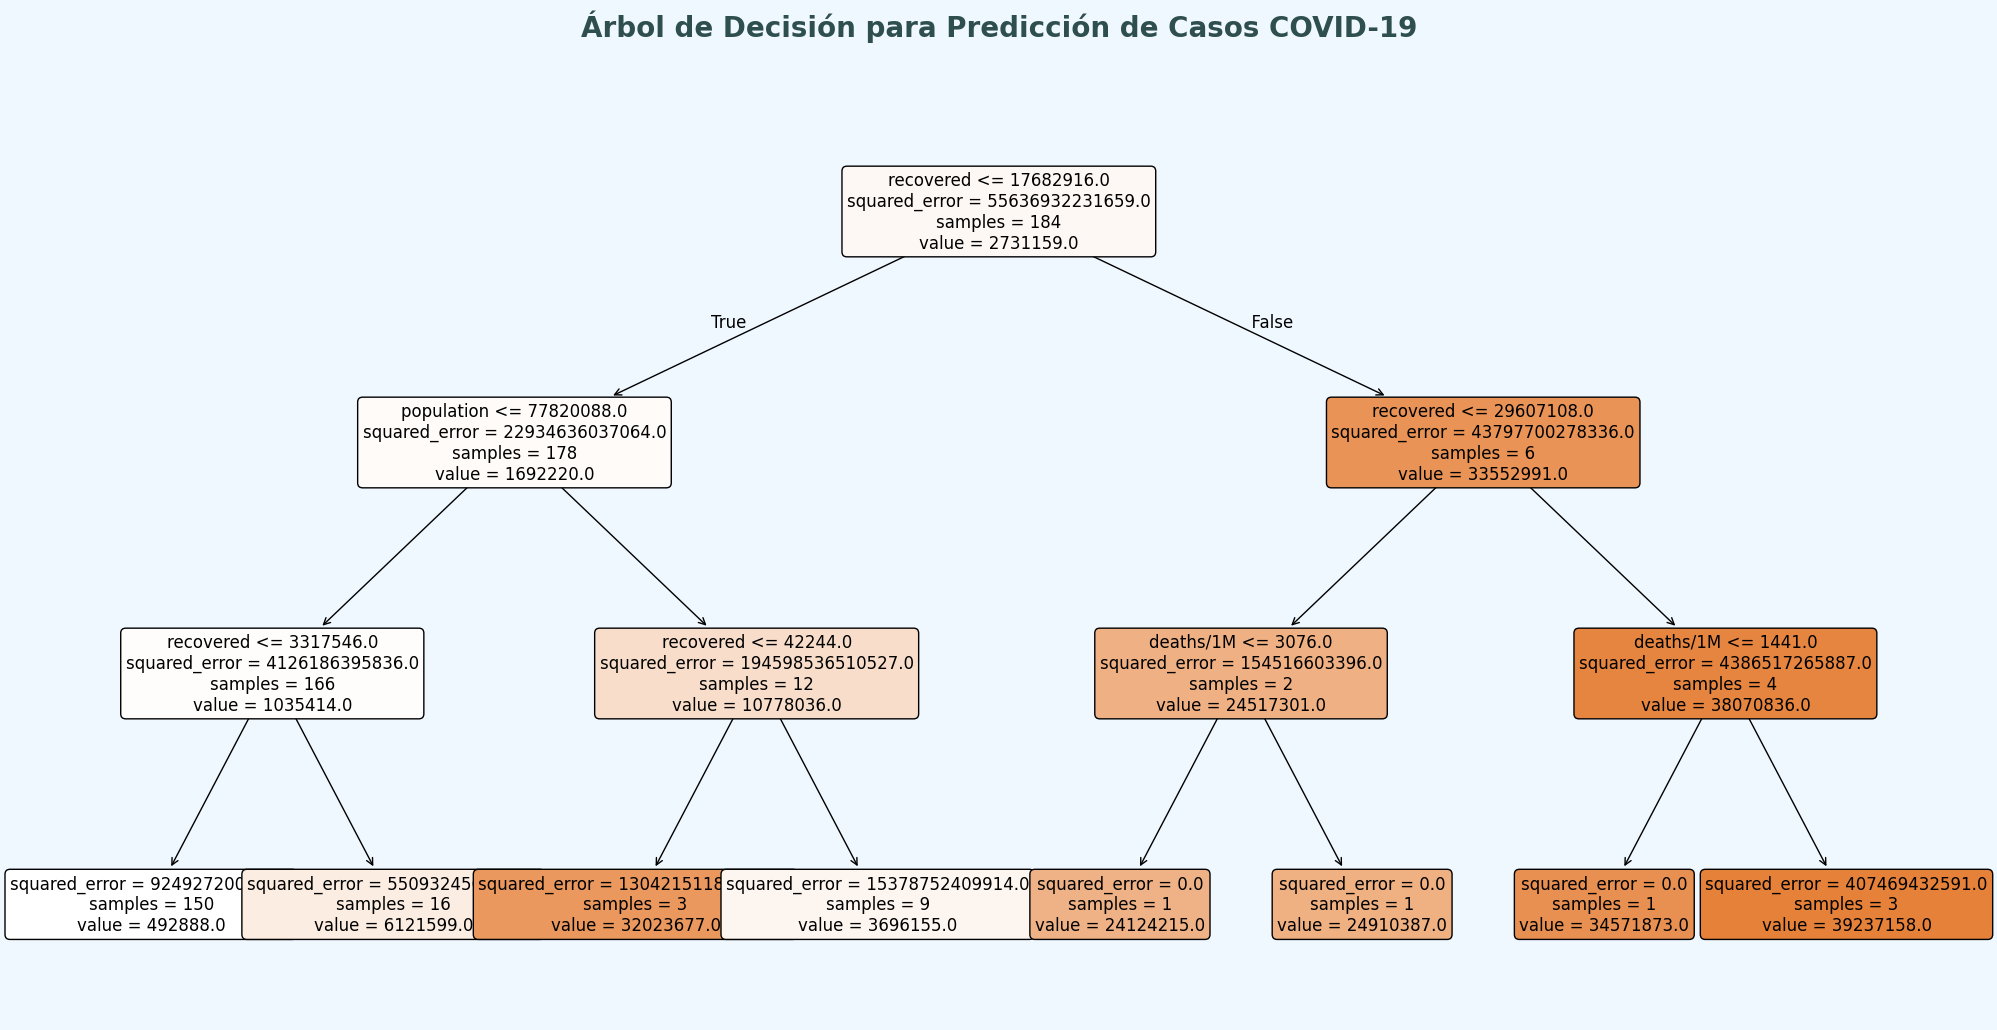

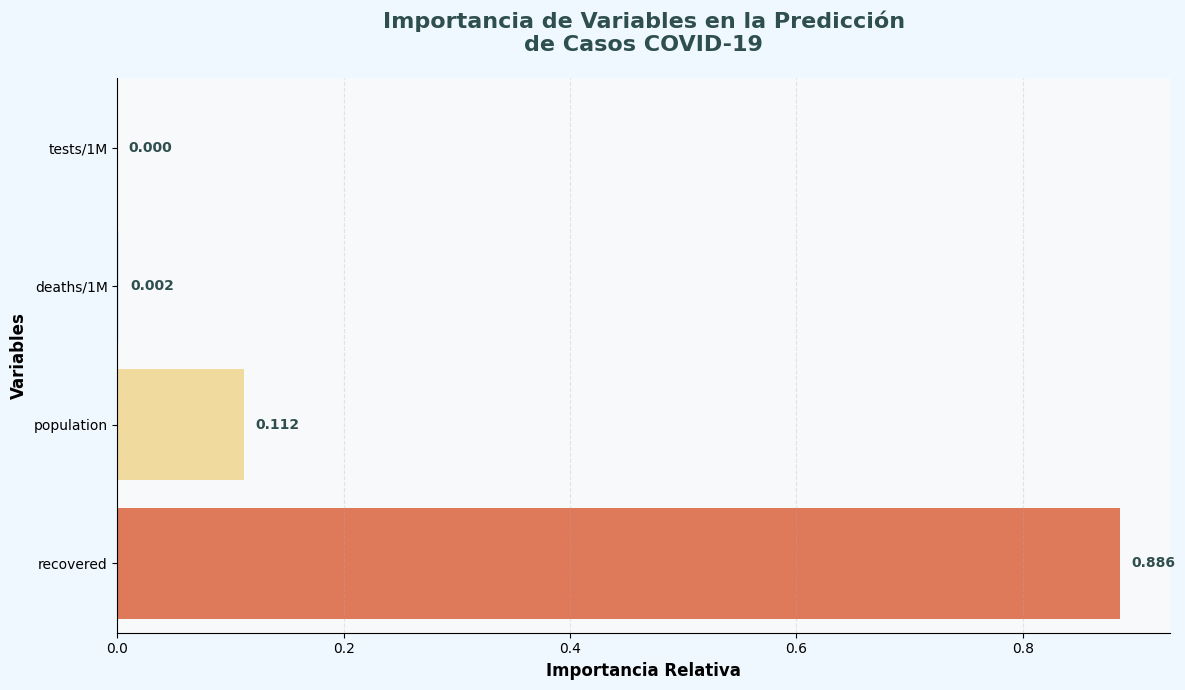


Métricas de Rendimiento del Modelo:
               Métrica              Valor
Error Cuadrático Medio 146021729365991.03
              R² Score              0.462


In [20]:
# Import required libraries
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Create and train the model
tree_model = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_model.fit(X_train, y_train)

# 1. Decision Tree Visualization
plt.figure(figsize=(25,12), facecolor='#f0f8ff')
feature_names = [name.replace('PerOneMillion', '/1M') for name in X.columns.tolist()]

plot_tree(tree_model,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          fontsize=12,
          max_depth=3,
          class_names=['Casos COVID'],
          precision=0)

plt.title('Árbol de Decisión para Predicción de Casos COVID-19\n',
         fontsize=20,
         fontweight='bold',
         pad=20,
         color='#2F4F4F')

# 2. Feature Importance Plot
plt.figure(figsize=(12,7), facecolor='#f0f8ff')
importances = pd.DataFrame({
    'features': feature_names,
    'importance': tree_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=True)

colors = sns.color_palette("RdYlBu_r", n_colors=len(importances))
ax = sns.barplot(data=importances,
                x='importance',
                y='features',
                palette=colors)

for i, v in enumerate(importances['importance']):
    ax.text(v + 0.01, i, f'{v:.3f}',
            va='center',
            fontweight='bold',
            color='#2F4F4F')

plt.title('Importancia de Variables en la Predicción\nde Casos COVID-19',
         fontsize=16,
         fontweight='bold',
         pad=20,
         color='#2F4F4F')
plt.xlabel('Importancia Relativa', fontsize=12, fontweight='bold')
plt.ylabel('Variables', fontsize=12, fontweight='bold')

ax.set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True, linestyle='--', alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# 3. Performance Metrics
y_pred = tree_model.predict(X_test)
metrics_df = pd.DataFrame({
    'Métrica': ['Error Cuadrático Medio', 'R² Score'],
    'Valor': [f'{mean_squared_error(y_test, y_pred):.2f}',
              f'{r2_score(y_test, y_pred):.3f}']
})

print("\nMétricas de Rendimiento del Modelo:")
print(metrics_df.to_string(index=False))


# Análisis Predictivo de Casos COVID-19

## 1. Preparación del Modelo

En este análisis predictivo de COVID-19, utilizamos las siguientes variables clave:

- Población total del país
- Tests realizados por millón de habitantes  
- Muertes por millón de habitantes
- Casos recuperados

Estas variables nos ayudan a predecir el número total de casos de COVID-19 en diferentes países.

## 2. Estructura del Modelo

El árbol de decisión está configurado con:

- **Profundidad máxima**: 3 niveles para evitar sobreajuste
- **Mínimo de muestras**: 5 para realizar una división
- **División de datos**: 80-20 (entrenamiento/prueba)

## 3. Visualizaciones y Resultados

### Árbol de Decisión

El árbol muestra las reglas de decisión que el modelo usa para predecir casos de COVID-19, considerando:

- Puntos de división óptimos para cada variable
- Predicciones en cada nodo terminal
- Flujo de decisiones basado en las características más relevantes

### Importancia de Variables

El gráfico de barras muestra:

- Ranking de variables según su poder predictivo
- Peso relativo de cada característica en el modelo
- Identificación de los factores más influyentes en la propagación del virus

---

Este análisis nos permite entender mejor los factores que más impactan en el número de casos de COVID-19, facilitando la toma de decisiones en salud pública y la asignación de recursos.


In [21]:
def get_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except:
        return None

# Add ISO3 codes to the dataframe
df['iso3'] = df['country'].apply(get_iso3)

def crear_dashboard_multinivel():
    fig = make_subplots(rows=2, cols=1,
                       row_heights=[0.6, 0.4],
                       specs=[[{"type": "choropleth"}],
                             [{"type": "bar"}]])

    # Mapa mundial
    fig.add_trace(
        go.Choropleth(
            locations=df['iso3'],
            z=df['cases'],
            text=df['country'],
            colorscale='Reds',
            visible=True,
            showscale=True,
            colorbar_title="Total Cases",
            name='World Map'
        ), row=1, col=1
    )

    # Gráfico de barras global
    fig.add_trace(
        go.Bar(
            name='Casos Globales',
            x=df.groupby('continent')['cases'].sum().index,
            y=df.groupby('continent')['cases'].sum(),
            visible=True,
            marker_color='#3498DB'
        ), row=2, col=1
    )

    # Boxplots por continente
    for continente in df['continent'].unique():
        datos_cont = df[df['continent'] == continente]
        fig.add_trace(
            go.Box(
                name=continente,
                y=datos_cont['casesPerOneMillion'],
                visible=False,
                marker_color='#2ECC71'
            ), row=2, col=1
        )

    # Scatter plot países
    fig.add_trace(
        go.Scatter(
            name='Países',
            x=df['testsPerOneMillion'],
            y=df['casesPerOneMillion'],
            mode='markers',
            text=df['country'],
            visible=False,
            marker=dict(
                color='#E74C3C',
                size=10,
                line=dict(color='#FFFFFF', width=1)
            )
        ), row=2, col=1
    )

    # Mejorar el estilo del selector
    fig.update_layout(
        updatemenus=[{
            'buttons': [
                {'method': 'update', 'label': '🌍 Global', 'args': [{'visible': [True, True] + [False] * (len(df['continent'].unique()) + 1)}]},
                {'method': 'update', 'label': '🌎 Continentes', 'args': [{'visible': [False, False] + [True] * len(df['continent'].unique()) + [False]}]},
                {'method': 'update', 'label': '🏳️ Países', 'args': [{'visible': [False, False] + [False] * len(df['continent'].unique()) + [True]}]}
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top',
            'bgcolor': '#2C3E50',
            'font': {'color': 'white'}
        }],
        title={
            'text': 'Dashboard COVID-19 Multinivel',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24, color='#2C3E50')
        },
        height=1000,
        width=1200,
        template='plotly_white',
        paper_bgcolor='#ECF0F1',
        plot_bgcolor='#FFFFFF',
        geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
        margin=dict(l=0, r=0, t=100, b=0)
    )

    return fig

def generar_informe_detallado(nivel, seleccion=None):
    if nivel == 'Global':
        datos = df
    elif nivel == 'Continentes':
        datos = df[df['continent'] == seleccion]
    else:
        datos = df[df['country'] == seleccion]

    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0/css/all.min.css">
        <style>
            .dashboard-container {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                max-width: 1200px;
                margin: 20px auto;
                padding: 30px;
                background: linear-gradient(135deg, #ffffff 0%, #f8f9fa 100%);
                border-radius: 15px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            }}
            .dashboard-title {{
                color: #2C3E50;
                font-size: 2.5em;
                text-align: center;
                margin-bottom: 30px;
                border-bottom: 3px solid #3498DB;
                padding-bottom: 10px;
            }}
            .stats-grid {{
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
                gap: 20px;
                margin-top: 20px;
            }}
            .stat-card {{
                background: white;
                padding: 20px;
                border-radius: 10px;
                box-shadow: 0 2px 4px rgba(0, 0, 0, 0.05);
                transition: transform 0.3s ease;
            }}
            .stat-card:hover {{
                transform: translateY(-5px);
            }}
            .stat-title {{
                color: #7F8C8D;
                font-size: 0.9em;
                margin-bottom: 10px;
            }}
            .stat-value {{
                color: #2C3E50;
                font-size: 1.8em;
                font-weight: bold;
            }}
            .icon {{
                color: #3498DB;
                margin-right: 10px;
            }}
        </style>
    </head>
    <body>
        <div class="dashboard-container">
            <h1 class="dashboard-title">
                <i class="fas fa-virus icon"></i>
                {nivel}: {seleccion if seleccion else 'Visión General'}
            </h1>
            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-title"><i class="fas fa-hospital-user icon"></i>Total Casos</div>
                    <div class="stat-value">{datos['cases'].sum():,}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-title"><i class="fas fa-heart-broken icon"></i>Total Muertes</div>
                    <div class="stat-value">{datos['deaths'].sum():,}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-title"><i class="fas fa-percentage icon"></i>Tasa Mortalidad</div>
                    <div class="stat-value">{(datos['deaths'].sum()/datos['cases'].sum()*100):.2f}%</div>
                </div>
                <div class="stat-card">
                    <div class="stat-title"><i class="fas fa-vial icon"></i>Tests por Millón</div>
                    <div class="stat-value">{datos['testsPerOneMillion'].mean():,.0f}</div>
                </div>
            </div>
        </div>
    </body>
    </html>
    """
    return HTML(html_content)

# Generar y mostrar dashboard
dashboard = crear_dashboard_multinivel()
dashboard.show()

# Mostrar informes
display(generar_informe_detallado('Global'))


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed